# TP1

Importamos las librerias necesarias.

In [356]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Generador de enteros de 32 bits de periodo 2^128 - 1. Debido a que Python no tiene el problema de desbordamiento de enteros, limitamos la operación para números de 32 bits.

In [357]:
class XORSHIFT128:
    def __init__(self, x, y, z, w):
        self.periodo = 2**128 - 1
        self.x = x
        self.y = y
        self.z = z
        self.w = w

    def rnd(self):
        tmp = (self.x^(self.x<<11)) & 0xFFFFFFFF # Resultado en 32 bits
        self.x=self.y
        self.y=self.z
        self.z=self.w
        self.w = (self.w ^ (self.w >> 19)) ^ (tmp ^ (tmp >> 8)) & 0xFFFFFFFF # Resultado en 32 bits
        return self.w
        
    def rnd_cero_uno(self):
        return self.rnd()/(2**32 - 1)

generador = XORSHIFT128(123456789, 362436069, 521288629, 88675123)
for _ in range(5):
    numero_generado = generador.rnd()
    print(numero_generado, type(numero_generado))

3701687786 <class 'int'>
458299110 <class 'int'>
2500872618 <class 'int'>
3633119408 <class 'int'>
516391518 <class 'int'>


Para generar números aleatorios entre 0 y 1 debemos dividir entre el numero maximo. Para resolver este ítem se implementó el método rnd_cero_uno()

In [358]:
for _ in range(5):
    numero_generado = generador.rnd_cero_uno()
    print(numero_generado)

0.5535012051820525
0.6053478875209922
0.16699309185310107
0.03209956549855405
0.09204706016277127


## Vemos que tan bueno es el generador

Primero vemos que tan bien se distribuye entre el 0 y 1.

In [359]:
observaciones = []
for _ in range(10**5):
  observaciones.append(generador.rnd_cero_uno())

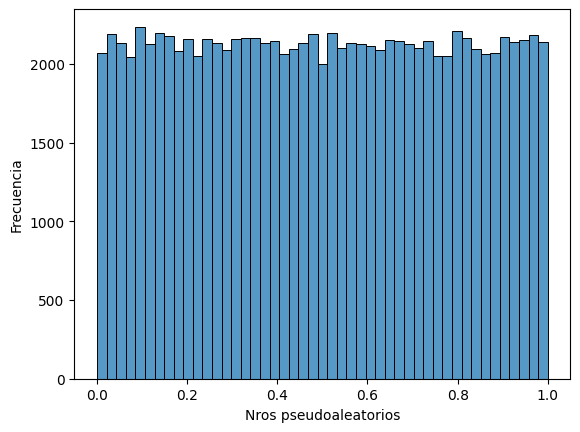

In [360]:
sns_hist=sns.histplot(data=observaciones).set(xlabel="Nros pseudoaleatorios",ylabel="Frecuencia")
plt.show()

Observamos que tiene una buena distribucion.

Ahora vemos si hay algun patrón en la distribución.

In [361]:
limit=1000
n_obs = observaciones[:limit]
n_plus_1_obs = observaciones[1:limit+1]

Vemos si hay algun patrón entre una muestra de los números generados y sus consecutivos.

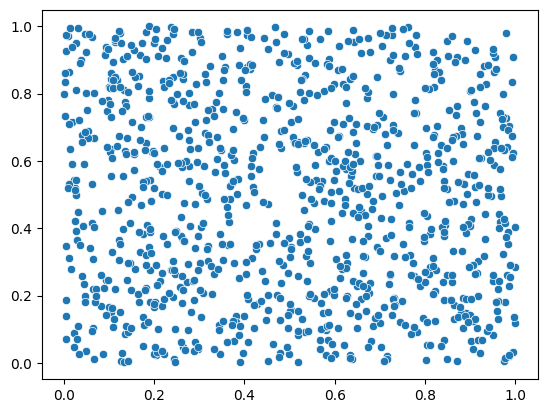

In [362]:
sns_scat=sns.scatterplot(x=n_obs, y=n_plus_1_obs)
plt.show()

Vemos que los puntos no muestran ningún patrón a simple vista.

Para generar números aleatorios entre 0 y 1 debemos dividir entre el numero maximo. Para resolver este ítem se implementó el método rnd_cero_uno()

In [3]:
for _ in range(5):
    numero_generado = generador.rnd_cero_uno()
    print(numero_generado)

0.5892699746390037
0.34841345817512215
0.051142619003342146
0.4295861915288461
0.7373511206212805


## Vemos que tan bueno es el generador

Primero vemos que tan bien se distribuye entre el 0 y 1.

In [72]:
observaciones = []
for _ in range(10**5):
  observaciones.append(generador.rnd_cero_uno())

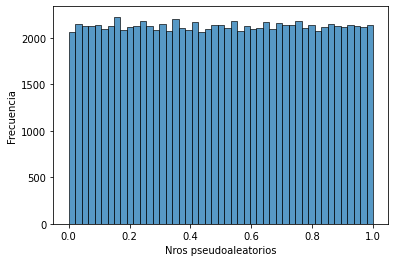

In [25]:
sns_hist=sns.histplot(data=observaciones).set(xlabel="Nros pseudoaleatorios",ylabel="Frecuencia")
plt.show()

Observamos que tiene una buena distribucion.

Ahora vemos si hay algun patrón en la distribución.

In [97]:
limit=1000
n_obs = observaciones[:limit]
n_plus_1_obs = observaciones[1:limit+1]

Vemos si hay algun patrón entre una muestra de los números generados y sus consecutivos.

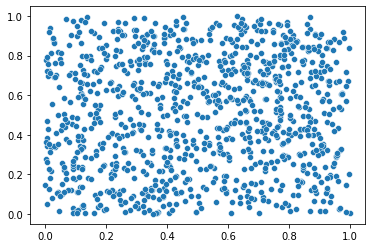

In [95]:
sns_scat=sns.scatterplot(x=n_obs, y=n_plus_1_obs)
plt.show()

Vemos que los puntos no muestran ningún patrón a simple vista.